# **Unified classification and risk-stratification in Acute Myeloid Leukemia**


>>> # **Tutorial for Summary Plots, similar to the web app** : 

### This notebook is independent of the paper figures and can be used for a detailed overview of specific molecular data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.stats import fisher_exact, ranksums, chi2, norm, spearmanr, mannwhitneyu, chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests
from sksurv.nonparametric import kaplan_meier_estimator

## **Functions for the summary plots.**

In [2]:
###############
# Logrank tests
###############
  
def custom_logrank_test(dataframes, type='CMH_logrank'):
    list_data_y = []

    for df in dataframes:
        df_slct = df[['os_status', 'os']].dropna()

        data_y = np.array([(status, time) for status, time in zip(df_slct.os_status, df_slct.os)],
                          dtype=[('os_status', '?'), ('os', np.float)])
        list_data_y.append(data_y)

    n_groups = len(list_data_y)
    n = sum([l.shape[0] for l in list_data_y])
    df = n_groups - 1

    d = np.zeros((1, n_groups - 1))  # Row vector d sums number of events (deaths) for first n_groups-1 groups pver each distinct time
    E = np.zeros((1, n_groups - 1))  # Row vector d sums expected number of events (deaths) for first n_groups-1 groups over each distinct time
    V = np.zeros((n_groups - 1, n_groups - 1))  # Matrix V will sums variances of number of events (deaths) for first n_groups-1 groups over distinct times
    W = []  # List of list W will record scores for each group at each distinct time
    r_t = [l.shape[0] for l in list_data_y]  # r_t stores at each time t the number at risk in each group

    lbda = 0  # Lbda is the Nelson-Aalen estimate of the cumulative hazard for all groups combined
    # It is used as a score for the linear rank test statistic

    for t in sorted(np.unique(np.concatenate([l['os'] for l in list_data_y]).flatten())):
        d_t = []
        E_t = []
        W_t = []

        for k in range(n_groups):
            d_t.append(list_data_y[k][(list_data_y[k]['os'] == t) & (list_data_y[k]['os_status'] == True)].shape[0])
        for k in range(n_groups):
            E_t.append(sum(d_t) * r_t[k] / sum(r_t))

        d += np.array([d_t[:-1]])
        E += np.array([E_t[:-1]])
        lbda += sum(d_t) / sum(r_t)

        for k in range(n_groups):
            w_k = []
            for s in list_data_y[k][list_data_y[k]['os'] == t]:
                if s['os_status'] == True:
                    w_k.append(1 - lbda)
                else:
                    w_k.append(-lbda)
            W_t.append(w_k)
        W.append(W_t)

        if sum(r_t) > 1:
            V_t = []
            for i in range(n_groups):
                r_i = []
                for j in range(n_groups):
                    if i != j:
                        r_i.append(-(sum(r_t) - sum(d_t)) * sum(d_t) * r_t[i] * r_t[j] / ((sum(r_t) - 1) * sum(r_t) ** 2))  # Pay attention to the - sign for covariance term
                    else:
                        r_i.append((sum(r_t) - sum(d_t)) * sum(d_t) * r_t[i] * (sum(r_t) - r_t[i]) / ((sum(r_t) - 1) * sum(r_t) ** 2))
                V_t.append(r_i)
            V_t = np.array(V_t)
            V += (V_t[:-1, :-1])

        r_t = [r - e[e['os'] == t].shape[0] for r, e in zip(r_t, list_data_y)]  # Update number of patients at risk in each group

    if type == 'CMH_logrank':  # Cochran-Mantel-Haenszel

        # Suppose we have k (2x2) tables, all independent and we want to test for
        # a common group effect. This is the Cochran-Mantel-Haenszel that, in case
        # of survival analysis, tests for odds ratio being 1 at all times

        # Null hypothesis H0: odds ratio is 1 for all tables

        statistic = (d - E).dot(np.linalg.inv(V).dot(d - E))
        p_value = 1 - chi2.cdf(statistic, df)

    elif type == 'Linear_rank_logrank':
        if n_groups > 2:
            raise ValueError("Linear_rank_logrank statistic is not yet implemented for comparison between more than 2 groups.")

        else:
            # The linear rank version of the logrank test is based on adding up "scores" for one of the 2 groups
            # The "score" is based on the Nelson-Aalen estimator
            # Null hypothesis H0: odds ratio is 1 for all tables

            S = np.concatenate(pd.DataFrame(W).iloc[:, 0]).sum()
            V = list_data_y[0].shape[0] * list_data_y[1].shape[0] * sum([sum(np.concatenate(pd.DataFrame(W).iloc[:, i]) ** 2) for i in range(n_groups)]) / (n * (n - 1))
            statistic = S ** 2 / V
            p_value = 1 - chi2.cdf(statistic, df)

    else:
        raise ValueError("Unsupported type %s. Choose one of: 'CHM_logrank', 'linear_rank_logrank'." % type)

    return statistic, df, p_value

  
#######################################
# Functions to plot Kaplan-Meier curves
#######################################

def plot_km(dataframe, label, mask_label, ax, color=None, label_legend=False, lw=None, scatter_s=None):

    """
    This function creates a plot with a Kaplan-Meier curve of overall survival
    for the input dataframe. The latter must have columns "os" and "os_status".

    :param dataframe: pandas.DataFrame
        Input, typically output of selection of a particular population
    :param label: string
        Name to give to the population of dataframe
    :param mask_label: string
        Mask used for creating the input dataframe
    :param ax: Axes object
        Axes in which to plot
    :param color: string
        Default:None
    :param label_legend: boolean
        If True, uses mask_label to label the curve. Default:False
    :param lw: integer
        Linewidth of the curves. Default:None
    :param scatter_s: integer
        Size of the scatter points for censored patients. Default: None
    :return:
    """

    df_nmos = dataframe[['os_status', 'os']].dropna()

    if df_nmos.shape[0] == 0:
        print('Patients for dataset %s and mask %s all N.A for os or os_status' % (label,mask_label))
    elif (df_nmos.os_status.nunique() == 1 and df_nmos.os_status.unique()[0] == False):
        print('Patients for dataset %s and mask %s are all censored' % (label,mask_label))
    else:
        data_y = np.array([(status, time) for status, time in zip(df_nmos.os_status, df_nmos.os)],
                          dtype=[('os_status', '?'), ('os', np.float)])

        time, survival_prob = kaplan_meier_estimator(data_y['os_status'], data_y['os'])
        time = np.insert(time, 0, 0)
        survival_prob = np.insert(survival_prob, 0, 1.0)

        time_censored, prob_censored = [], []
        for t, p in zip(time, survival_prob):
            if False in data_y[data_y['os'] == t]['os_status']:
                time_censored.append(t), prob_censored.append(p)

        ax.scatter(time_censored, prob_censored, color=color, marker='+', s=scatter_s)
        if label_legend:
            ax.step(time, survival_prob, color=color, label='%s n=%d'%(mask_label,data_y.shape[0]), linewidth=lw)
        else:
            ax.step(time, survival_prob, color=color, label='n=%d'%data_y.shape[0], linewidth=lw)

def plot_compare_km(dataframes, labels, mask_labels, ax, colors, linestyles=['-','-'], label_legend=None, test_statistic='default', xy_statistic=(0.6,0.8), font_size_statistic='small', lw=None,
                    scatter_s=None):
    """
    This function creates a plot with Kaplan-Meier curves of overall survival
    for the list of dataframes. The latter must have columns "os" and "os_status".

    :param dataframes: list
        Groups for the KM curves, list of dataframes.
    :param labels: list
        List of strings used to label the curves if label_legend is 'dataset'
    :param mask_labels: list
        List of strings used to label the curves if label_legend is 'mask' and to print warning messages
    :param ax: Axes object
        Axes in which to plot
    :param colors: list
        List of colors names
    :param linestyles: list
        List of linestyles to be used for curves. Must be same size as dataframes. Default: ['-','-']
    :param label_legend: string
        Must be one of 'dataset', 'label' or None. This tells which labels to put in the legend. Default: None
    :param test_statistic: string
        Which test_statistic to use for comparing curves. For the moment only 'CMH_logrank' is available for more than 2 curves and 'linear_rank_logrank' for 2 curves.
        Default:'CMH_logrank'
    :param xy_statistic: tuple
        Coordinates in the axes fraction units to print the p-value of the test. Default: (0.6, 0.8)
    :param font_size_statistic: string
        Fontsize to print the p-value of the test. Default: 'small'
    :param lw: integer
        Linewidth of the curves. Default:None
    :param scatter_s: integer
        Size of the scatter points for censored patients. Default: None
    :return:
    """
    list_data_y = []

    for df, label, mask_label, c, ls in zip(dataframes, labels, mask_labels, colors, linestyles):
        if df.shape[0] == 0:
            print('0 patient for dataset %s and mask %s' % (label, mask_label))

        else:
            df_slct = df[['os_status', 'os']].dropna()

            if df_slct.shape[0] == 0:
                print('Patients for dataset %s and mask %s all N.A for os or os_status' % (label, mask_label))
            elif (df_slct.os_status.nunique() == 1 and df_slct.os_status.unique()[0] == False):
                print('Patients for dataset %s and mask %s are all censored' % (label, mask_label))
            else:
                data_y = np.array([(status, time) for status, time in zip(df_slct.os_status, df_slct.os)],
                                  dtype=[('os_status', '?'), ('os', np.float)])
                list_data_y.append(data_y)
                time, survival_prob = kaplan_meier_estimator(data_y['os_status'], data_y['os'])
                time = np.insert(time, 0, 0)
                survival_prob = np.insert(survival_prob, 0, 1.0)

                time_censored, prob_censored = [], []
                for t,p in zip(time,survival_prob):
                    if False in data_y[data_y['os']==t]['os_status']:
                        time_censored.append(t), prob_censored.append(p)

                ax.scatter(time_censored, prob_censored, color=c, marker='+', s=scatter_s)
                if label_legend==None:
                    ax.step(time, survival_prob, color=c, label='n=%d' % data_y.shape[0], linestyle=ls, linewidth=lw)
                elif label_legend=='dataset':
                    ax.step(time, survival_prob, color=c, label='%s n=%d' % (label, data_y.shape[0]), linestyle=ls, linewidth=lw)
                elif label_legend=='mask':
                    ax.step(time, survival_prob, color=c, label='%s n=%d' % (mask_label, data_y.shape[0]), linestyle=ls, linewidth=lw)
                else:
                    raise ValueError('Unsupported value of label_legend \n Must be one of [None,"dataset","mask"]')

    dataframes_statistic = []
    for df in dataframes:
        if df.shape[0] > 5:
            dataframes_statistic.append(df)

    if len(dataframes_statistic) >= 2:
        if test_statistic == 'CMH_logrank':
            statistic, df, p_value = custom_logrank_test(dataframes_statistic, type='CMH_logrank')

            if p_value < 0.001:
#                 s = '$\chi^2$ P<0.001'
                  s = 'P<0.001'
            else:
#                 s = '$\chi^2$ P=%.3f' % p_value
                s = 'P=%.3f' % p_value
            ax.annotate(text=s, xy=xy_statistic, xycoords='axes fraction', fontsize=font_size_statistic)

        elif test_statistic == 'Linear_rank_logrank':
            if len(list_data_y) > 2:
                raise ValueError('For test_statistic equal to Linear_rank_logrank only 2 groups are permitted')
            else:
                statistic, df, p_value = custom_logrank_test(dataframes_statistic, type='Linear_rank_logrank')

                if p_value < 0.001:
#                     s = '$\chi^2$ P<0.001'
                    s = 'P<0.001'
                else:
#                     s = '$\chi^2$ P=%.3f' % p_value
                    s = 'P=%.3f' % p_value
                ax.annotate(text=s, xy=xy_statistic, xycoords='axes fraction', fontsize=font_size_statistic)

        elif test_statistic != None:
            raise ValueError("Unsupported value of test_statistic \n Must be one of: None, CMH_logrank, Linear_rank_logrank.")

In [3]:
def multiplot_events(events_to_plot=["NPM1"],comutated_events="",save=False,display=["NPM1"],no_separation=False):
    eln_classes = ['Favorable', 'Intermediate', 'Adverse']
    for gene_col in events_to_plot:
        fig = plt.figure(figsize=(40,40) if no_separation==True else (25,20))
        outer = gridspec.GridSpec(nrows=18, ncols=18)
        

    #Remove root gene when gene col is a hotspot
##=======================================================================================================================   Comutations   
        gene_root = gene_col.split('_')[0]
        gene_hotspots = [x for x in comutated_events if x.startswith(gene_root)]
        df_comutations = df.loc[df[gene_col] == 1].loc[:, comutated_events].sum(axis=0).drop(gene_hotspots, axis=0).to_frame()
        df_comutations = pd.concat([df_comutations, df.loc[df[gene_col] == 0].loc[:, comutated_events].sum(axis=0).drop(gene_hotspots, axis=0).to_frame()], axis=1)


        df_comutations.columns = ['mut','wt']
        df_comutations = df_comutations.loc[(df_comutations.wt!=0) | (df_comutations.mut!=0)]

        n_mut = df.loc[df[gene_col]==1].shape[0]
        n_wt = df.loc[df[gene_col]==0].shape[0]
        df_comutations.loc[:,'mut'] = df_comutations.loc[:, 'mut']/n_mut
        df_comutations.loc[:, 'wt'] = df_comutations.loc[:, 'wt'] / n_wt

        df_comutations = df_comutations.reset_index()
        df_comutations.columns = ['gene', 'mut', 'wt']
        df_comutations.gene = df_comutations.gene.astype('category')
        df_comutations.gene.cat.set_categories(comutated_events, inplace=True)
        df_comutations.sort_values(['gene'], inplace=True)
        df_comutations.gene = df_comutations.gene.astype('str')
        df_comutations.set_index(['gene'], inplace=True)

        #del df_comutations.index.name
        #inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:6, 7:],wspace=0)
        inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[12:18, 1:16],wspace=0) if no_separation else gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:18, 1:16],wspace=0)
        ax_inner = plt.Subplot(fig, inner[0])

        g = sns.barplot(x=df_comutations.mut, y=df_comutations.index,ax=ax_inner)
        threshold = 0.05
        p_values = []
        oddsratios = []

#         gene_cyto =[]
#         list_cyto = []
        for gene_comut in df_comutations.index:
            wt_wt = df[(df[gene_col]==0) & (df[gene_comut]==0)].shape[0]
            wt_mut = df[(df[gene_col]==0) & (df[gene_comut] == 1)].shape[0]
            mut_wt = df[(df[gene_col]==1) & (df[gene_comut] == 0)].shape[0]
            mut_mut = df[(df[gene_col]==1) & (df[gene_comut] == 1)].shape[0]

            oddsratio,p_value = fisher_exact(table=[[wt_wt, wt_mut], [mut_wt, mut_mut]], alternative='two-sided')
            p_values.append(p_value)
            oddsratios.append(oddsratio)

        rej, p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

        list_associated = []
        list_exclusive = []
        for i, gene_comut in enumerate(df_comutations.index):
            if (p_values[i] < 0.05) & (oddsratios[i] > 1):
                list_associated.append(gene_comut)
            if (p_values[i] < 0.05) & (oddsratios[i] < 1):
                list_exclusive.append(gene_comut)
#             if(gene_comut in cyto_freq_cols):
#                 gene_cyto.append("cyto")
#             else:
#                 gene_cyto.append("gene")
#             if gene_comut in cyto_freq_cols:
#                 list_cyto.append(gene_comut)


        for idx,b in enumerate(g.patches):
            b.set_color("#5C5C5C")

            p_value = p_values[idx]
            oddsratio = oddsratios[idx]

            if p_value < threshold:
                if oddsratio < 1:
                    b.set_color('#5C5C5C')
                else:
                    b.set_color('#EE9937')



        b.set_edgecolor(color='white')
        b.set_height(1.0)

        g.invert_xaxis()
        g.set_xlabel('Fraction of samples carrying mutation', fontsize=22, fontweight='bold')

        major_ticks = np.arange(1, df_comutations.shape[0], 2)
        minor_ticks = np.arange(0, df_comutations.shape[0], 2)

        g.set_yticks(major_ticks)
        g.set_yticks(minor_ticks)
        g.tick_params(axis = 'y', which = 'major', direction='in', pad=0)
        g.tick_params(axis = 'y', which = 'minor', labelsize = 0, length=0)
        g.set_yticklabels(labels=df_comutations.index.values[0::2],fontsize=12, fontweight='bold')

        for tick in g.get_yaxis().get_majorticklabels():
            tick.set_ha('right')

        for tick in g.get_xaxis().get_majorticklabels():
            tick.set_fontsize('large')

        g.yaxis.tick_left()
        g.yaxis.grid(color='lightgray', linestyle=':', linewidth=0.5)
        g.xaxis.grid(color='lightgray',linestyle='--',linewidth=0.5)

        for tick in g.get_yaxis().get_majorticklabels():
            tick.set_color("black")
    #             if tick.get_text() in list_cyto:
    #                 tick.set_color('black')


        if gene_col in gene_freq_cols:
            g.set_title('Comutations to %s mutated '% gene_col.replace("principal_component_",""), fontsize=22, fontweight='bold')
        else:
            g.set_title('Comutations to %s ' % gene_col.replace("principal_component_",""), fontsize=22, fontweight='bold')
        fig.add_subplot(ax_inner)

        ax_inner = plt.Subplot(fig, inner[1])

        g = sns.barplot(x=df_comutations.wt, y=df_comutations.index,ax=ax_inner)

        for idx,b in enumerate(g.patches):
            b.set_color("#5C5C5C")

            p_value = p_values[idx]
            oddsratio = oddsratios[idx]

            if p_value < threshold:
                if oddsratio < 1:
                    b.set_color('#5C5C5C')
                else:
                    b.set_color('#EE9937')

            b.set_edgecolor(color='white')
            b.set_height(1.0)


        g.set_xlabel('Fraction of samples carrying mutation', fontsize=22, fontweight='bold')
        g.xaxis.set_major_locator(MaxNLocator(prune='lower'))

        major_ticks = np.arange(1, df_comutations.shape[0], 2)
        minor_ticks = np.arange(0, df_comutations.shape[0], 2)

        g.set_yticks(major_ticks)
        g.set_yticks(minor_ticks,minor=True)
        g.tick_params(axis = 'y', which = 'major', direction='in', pad=0)
        g.tick_params(axis = 'y', which = 'minor', labelsize = 0, length=0)
        g.set_yticklabels(labels=df_comutations.index.values[1::2],fontsize=12, fontweight='bold')

        for tick in g.get_xaxis().get_majorticklabels():
            tick.set_fontsize('x-large')

        g.yaxis.tick_right()
        g.yaxis.grid(color='steelblue', linestyle='--', linewidth=0.5)
        g.xaxis.grid(color='lightgray',linestyle='--',linewidth=0.5)

        for tick in g.get_yaxis().get_majorticklabels():
            tick.set_color("black")
#             if tick.get_text() in list_cyto:
#                 tick.set_color('black')

        if gene_col in gene_freq_cols:
            g.set_title('Comutations to %s wild-type ' % gene_col.replace("principal_component_",""), fontsize=22, fontweight='bold')
        else:
            g.set_title('Comutations to not %s ' % gene_col.replace("principal_component_",""), fontsize=22, fontweight='bold')
        fig.add_subplot(ax_inner)
        
        if no_separation==False:
            fig.suptitle('Comutation plot for %s mutation' % gene_col.replace("principal_component_",""),fontsize=40,fontweight='bold')
            if save :
                fig.savefig('figures/summary_events/%s_summary_comutation.png' % gene_col, format='png')
            else : 
                pass
            plt.show(fig) if gene_col in display else plt.close(fig)            
            fig = plt.figure(figsize=(40,30))
            outer = gridspec.GridSpec(nrows=18, ncols=18)
            
        ##=======================================================================================================================   Surv Plots
        inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=outer[:3 ,1:10],wspace=0) if no_separation else gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=outer[0:5, 1:10],wspace=0)

        for j, eln_class in enumerate(["All patients"]+eln_classes):
            ax_inner = plt.Subplot(fig, inner[j])
            if eln_class =="All patients":
                df_other = df.loc[df[gene_col]==0]
                df_slct = df.loc[df[gene_col]==1]
            else:
                df_other = df.loc[(df.eln==eln_class) & (df[gene_col]==0)]
                df_slct = df.loc[(df.eln==eln_class) & (df[gene_col]==1)]
            

            plot_compare_km(dataframes=[df_slct,df_other],
                            labels=['%s  mut' % (gene_col.replace("principal_component_","")), ' all others' ],
                            mask_labels=[eln_class, eln_class],
                            ax=ax_inner,
                            colors=["#EE9937","#5C5C5C"],
                            linestyles=['-','--'],
                            label_legend='dataset',
                            test_statistic='CMH_logrank',
                            xy_statistic=(0.4, 0.65),
                            font_size_statistic='x-large')

            if j==0:
                ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize=25, fontweight='bold')
            else:
                ax_inner.set_yticks([])
            ax_inner.set_xlabel('OS time (years)', fontsize=22, fontweight='bold')
            ax_inner.set_xlim(left=0.,right=9.)
            ax_inner.tick_params(axis='both', which='major', labelsize=22)
            ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
            ax_inner.set_ylim([0.,1.])
            ax_inner.legend(loc='upper right', fontsize=15)
            ax_inner.set_title(eln_class, fontsize=25, fontweight='bold')

            fig.add_subplot(ax_inner)

        inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[:3 ,11:],wspace=0) if no_separation else gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[0:5,11:],wspace=0)

        for i, title in enumerate(['Age < 60 ', 'Age >= 60 ']):
            ax_inner = plt.Subplot(fig, inner[i])
            if title == 'Age < 60 ':
                df_other = df.loc[(df.age < 60) & (df[gene_col]==0)]
                df_slct = df.loc[(df.age < 60) & (df[gene_col]==1)]
            else:
                df_other = df.loc[(df.age >= 60) & (df[gene_col]==0)]
                df_slct = df.loc[(df.age >= 60) & (df[gene_col]==1)]


            plot_compare_km(dataframes=[df_slct, df_other],
                            labels=[gene_col.replace("principal_component_",""), 'all others' ],
                            mask_labels=[title, title],
                            ax=ax_inner,
                            colors=["#EE9937","#5C5C5C"],
                            linestyles=['-', '--'],
                            label_legend='dataset',
                            test_statistic='CMH_logrank',
                            xy_statistic=(0.4, 0.65),
                            font_size_statistic='x-large')


            ax_inner.set_yticks([])
            ax_inner.set_xlabel('OS time (years)', fontsize=22, fontweight='bold')
            ax_inner.set_xlim(left=0.,right=9.)
            ax_inner.tick_params(axis='both', which='major', labelsize=22)
            ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=7, prune='lower', integer=True))
            ax_inner.set_ylim([0., 1.])
            ax_inner.legend(loc='upper right', fontsize=15)
            ax_inner.set_title("%s " % (title), fontsize=25, fontweight='bold')

            fig.add_subplot(ax_inner)
    ##======================================================================================================================= End Surv Plots

    ##=======================================================================================================================   Continuous Variables
        for i,cont in enumerate(["age","wbc","hb","plt","bm_blasts"]):
            inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[4:7,(3*i +1):3*(i+1)+1]) if no_separation else gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[6:11,(3*i +1):3*(i+1)+1])
            ax_inner = plt.Subplot(fig, inner[0])
            df_slct = df.loc[:,[gene_col]+[cont]]
            df_slct.loc[:,gene_col] = df_slct.loc[:,gene_col].map({0:'wt',1:'mut'})

            statistic, p_value = ranksums(df_slct.loc[df_slct[gene_col]=='wt',cont].dropna().values,df_slct.loc[df_slct[gene_col]=='mut',cont].dropna().values)
            if p_value<0.001:
                s='P < 0.001'
            else:
                s='P = %.3f'%p_value
            
            title = cont
            if(cont=="wbc"):
                title= "white blood cells"
            if(cont=="hb"):
                title="hemoglobin"
            if(cont=="plt"):
                title="platelet"

            #ax_inner.annotate(s=s, xy=(0.4,0.9), xycoords='axes fraction', fontsize='x-large')
            sns.boxplot(x=gene_col,y=cont,data=df_slct,ax=ax_inner,showfliers=False,palette= ["#EE9937","#5C5C5C"],order=["mut","wt"])
            ax_inner.set_title('Box plot of '+title,fontsize=25,fontweight='bold')
            ax_inner.tick_params(axis='both', which='major', labelsize=22)
            ax_inner.set_ylabel('', fontweight='bold')
            ax_inner.set_xlabel('%s' % gene_col.replace("principal_component_","") + " (" +s+")" , fontsize=22, fontweight='bold')
            fig.add_subplot(ax_inner)



    ##=======================================================================================================================   End Continuous Variables

    ##=======================================================================================================================    Categorical Variables
        for i,categ in enumerate(["gender","ahd","perf_status","secondary","eln"]):
            inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[8:11,(3*i +1):3*(i+1)+1]) if no_separation else gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[12:17,(3*i +1):3*(i+1)+1])
            ax_inner = plt.Subplot(fig, inner[0])
            df_slct = df.loc[:,[gene_col]+[categ]]
            df_slct.loc[:,gene_col] = df_slct.loc[:,gene_col].map({0:'wt',1:'mut'})

            #statistic, p_value = mannwhitneyu(df_slct.loc[df_slct[gene_col]=='wt',categ].dropna().values,df_slct.loc[df_slct[gene_col]=='mut',categ].dropna().values)
            crosstab = pd.crosstab(df_slct[gene_col].dropna().values, df_slct[categ].dropna().values)
            crosstab.apply(lambda c: c/c.sum() * 100, axis = 0)
            p_value = chi2_contingency(crosstab)[1]
            if p_value<0.05:
                s='P < 0.001'
            else:
                s='P = %.3f'%p_value

            if(categ=="gender"):
                title="gender"
            if(categ=="ahd"):
                title="AHD"
            if(categ=="perf_status"):
                title="performance status"
            if(categ=="secondary"):
                title="AML type"
            if(categ=="eln"):
                title="ELN 2017"
            #ax_inner.annotate(s=s, xy=(0.5,0.5),rotation=90, xycoords='axes fraction', fontsize='x-large')
            sns.countplot(x=gene_col,hue=categ,data=df_slct,ax=ax_inner,order=["mut","wt"])
            ax_inner.set_title('Bar plot of '+title,fontsize=25,fontweight='bold')
            ax_inner.tick_params(axis='both', which='major', labelsize=22)
            ax_inner.set_ylabel('', fontsize=22, fontweight='bold')
            ax_inner.set_xlabel('%s' % gene_col.replace("principal_component_","") + " (" +s+")" , fontsize=22, fontweight='bold')
            ax_inner.legend(fontsize='x-large')
            fig.add_subplot(ax_inner)



        fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.90, wspace=2, hspace=1)
            
        fig.suptitle('Multiple summary plots for %s mutation' % gene_col.replace("principal_component_", ""),fontsize=40,fontweight='bold')
        
        # if save & no_separation==False:
        #     fig.savefig('figures/summary_events/%s_summary_clinical_surv.png' % gene_col, format='png')
        # if save & no_separation==True:
        #     fig.savefig('figures/summary_events/%s_overall_summary.png' % gene_col, format='png')
        #     fig.savefig('figures/summary_events/%s_overall_summary.pdf' % gene_col, format='pdf')

        # Display only the first plot in the notebook
        if gene_col in display:
          plt.show(fig)
        else:
          plt.close(fig)

In [4]:
# Prepare data

df = pd.read_table("data/paper_aml_prognosis_updated.tsv",sep =' ')
df.loc[df['eln_2017'] == 1, 'eln'] = "Adverse"
df.loc[df['eln_2017'] == 2, 'eln'] = "Intermediate"
df.loc[df['eln_2017'] == 3, 'eln'] = "Favorable"
df.loc[df.age<60,"age_median"]=0
df.loc[df.age>=60,"age_median"]=1
df["gender"]=np.where(df['gender']==0, 'Female', 'Male')
df["ahd"]=np.where(df['ahd']==0, 'No', 'Yes')
df["secondary"]=np.where(df['secondary']==1, 'Primary',
                         np.where(df['secondary']==2,'Secondary','Others'))

molecular_classes = [c for c in df.columns if ( c.startswith( 'principal' ))]

gene_cols = sorted([c for c in df.columns if any((x.isupper()) & ~( c.startswith( 'final' )) & ~( c.startswith( 'full' )) & ~( c.startswith( 'princ' )) & ~( c.startswith( 'overlap' ))
                                                 & ~( c.startswith( '-Y' )) for x in c)])


gene_freq_cols = df.loc[:, gene_cols].sum(axis=0).sort_values(ascending=False)
gene_freq_cols = list(gene_freq_cols[gene_freq_cols >= 0.02*df.shape[0]].index)

# All cytos
cyto_cols = [x for x in df.columns if any(x.startswith(s) for s in
              ['t(', 'der', 'add', 'i(', 'dup', 'del', 'add', 'dic', 'inv(', 'abn', 'plus', 'minus', 'mono', 'complex','others_','-','+'])
              or x in (['ring', 'mar', 'dmin', 'hsr', 'ins'])]


cyto_freq_cols = df.loc[:, cyto_cols].sum(axis=0).sort_values(ascending=False)
cyto_freq_cols = list(cyto_freq_cols.loc[cyto_freq_cols >=  0.02*df.shape[0]].index)


events_order = df.loc[:, gene_freq_cols+cyto_freq_cols].sum(axis=0).sort_values(ascending=False).index
events_order = events_order.append(pd.Index(["inv(3)","t(15;17)","t(6;9)","t(9;11)"]))   # add . important ones
all_events_order = df.loc[:, gene_cols+cyto_cols].sum(axis=0).sort_values(ascending=False).index
eln_classes = ['Favorable', 'Intermediate', 'Adverse']

continuous_correlates = ["age","wbc","hb","plt","bm_blasts","os",]
categorical_correlates = ["gender","ahd","perf_status","secondary","os_status","eln_2017"]


# **Genes and  Cytos summaries.**


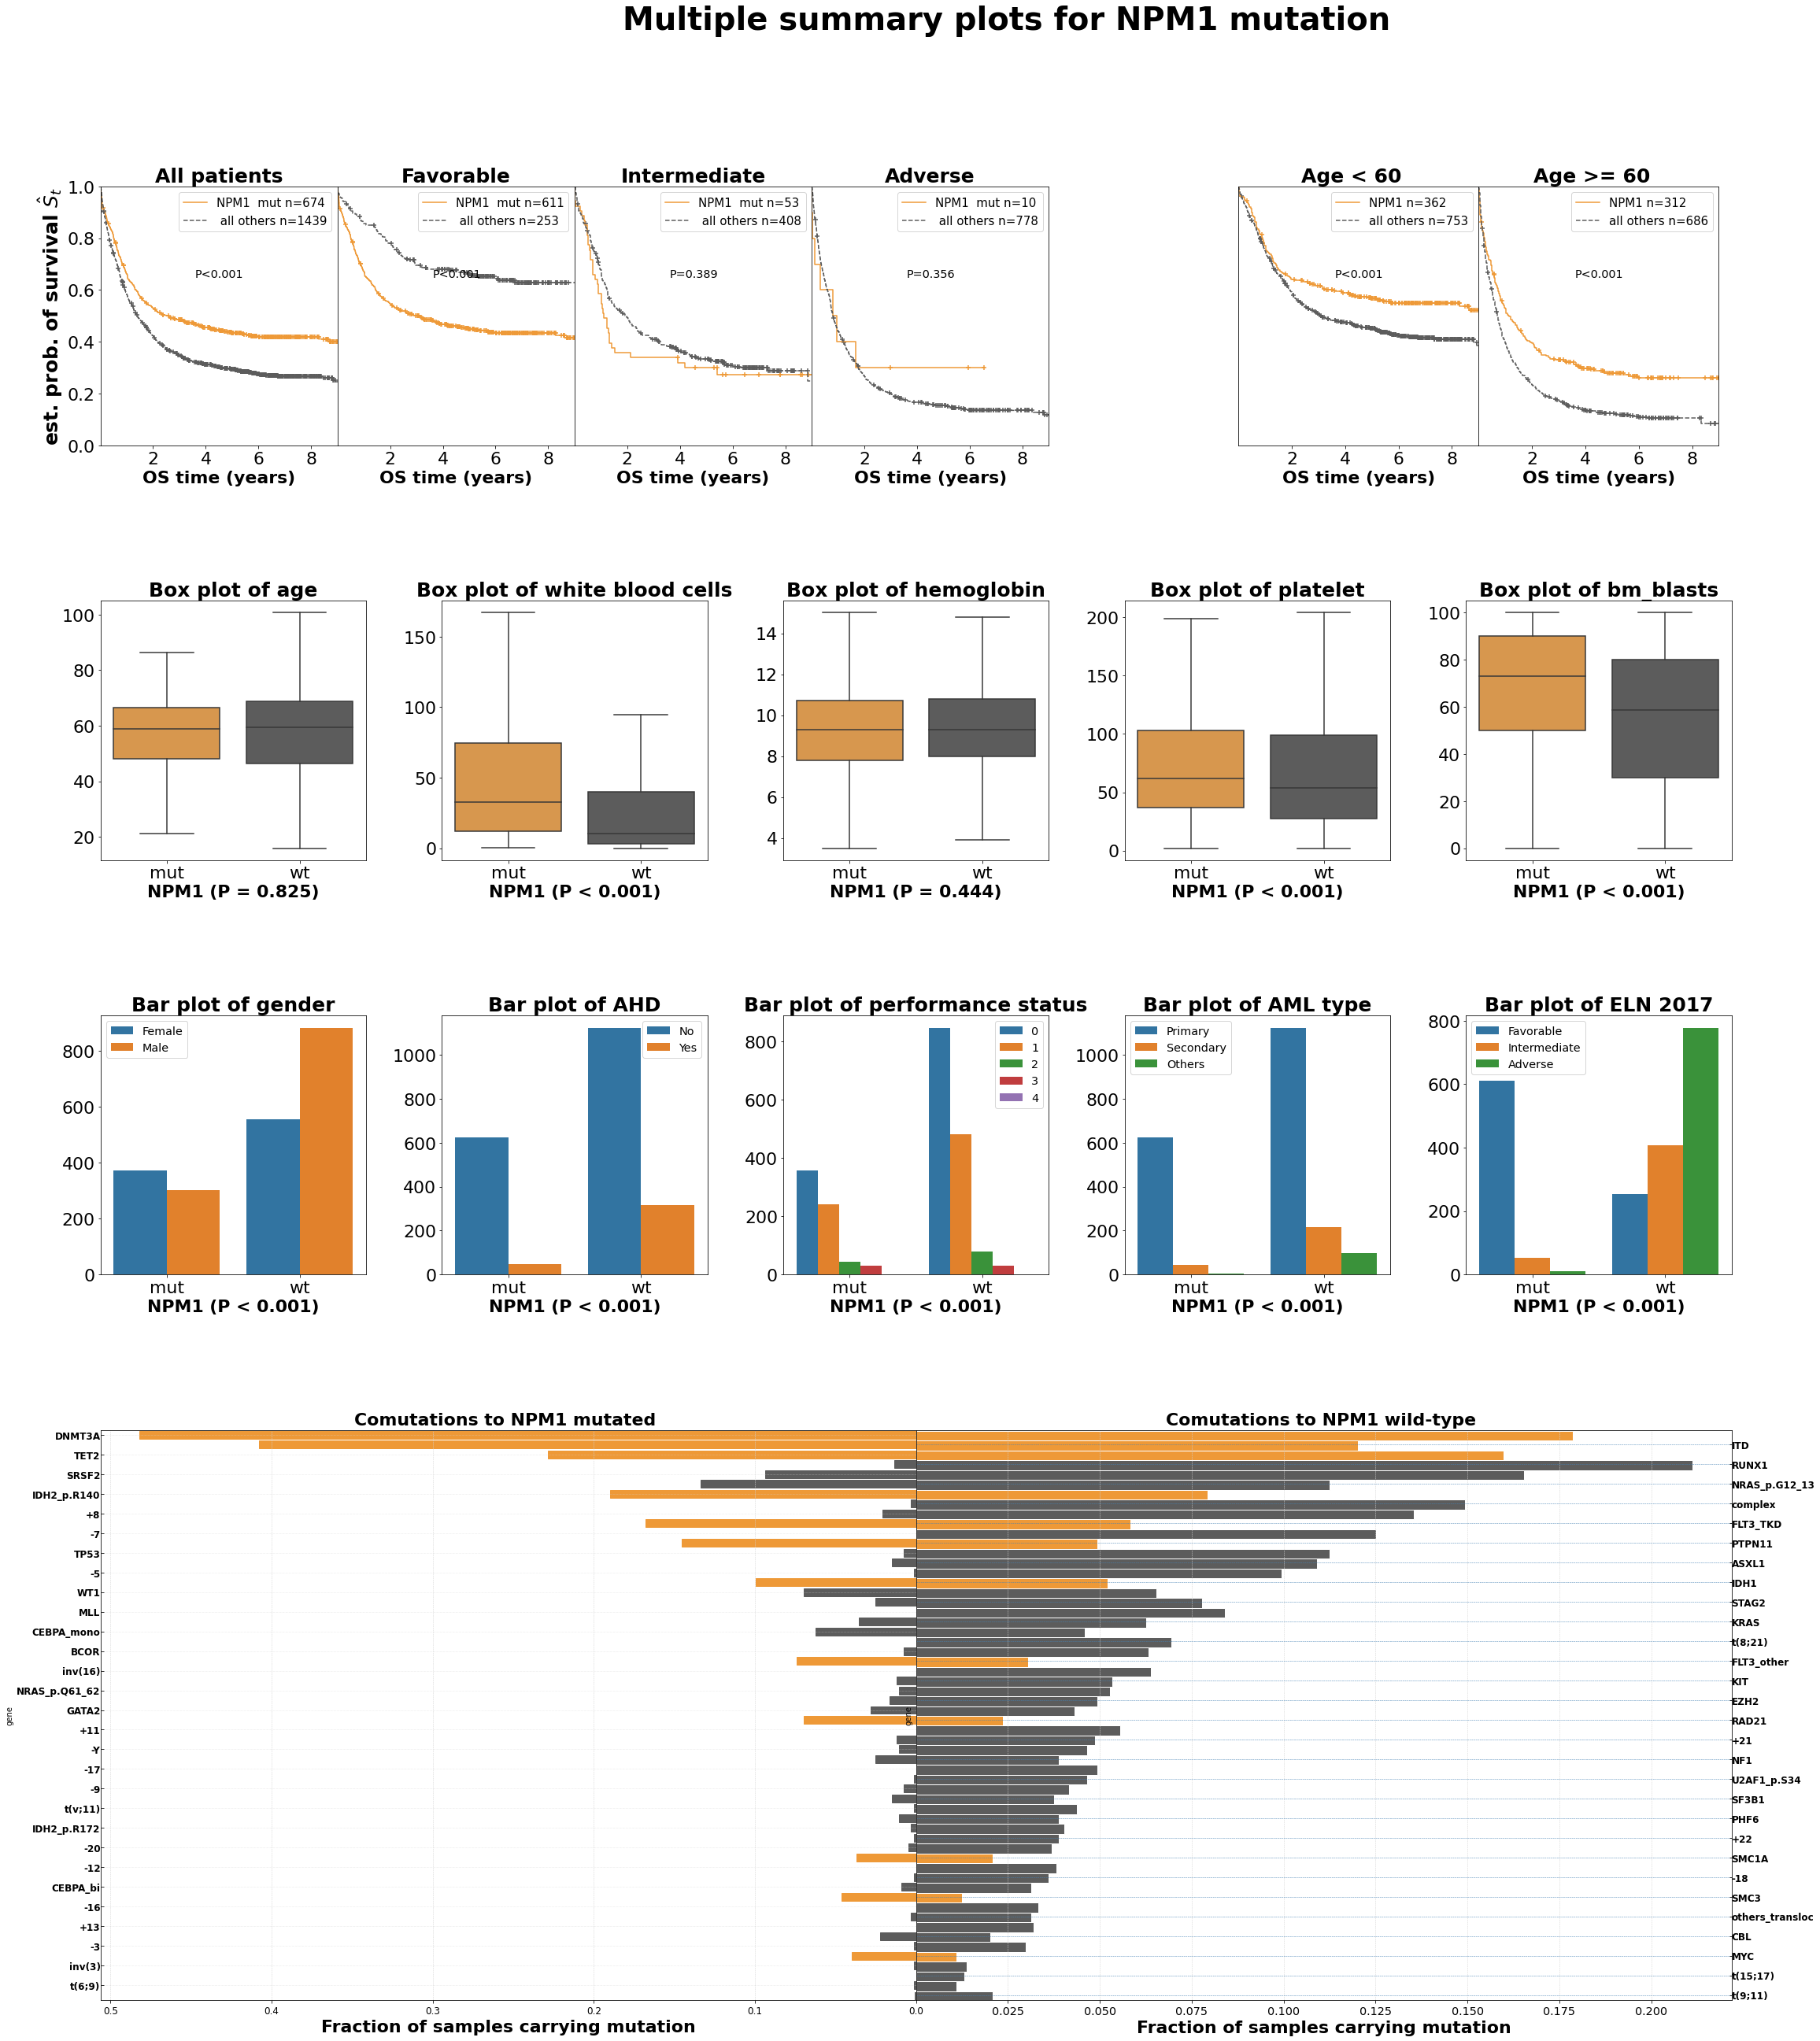

In [7]:
multiplot_events(events_to_plot=all_events_order[:1]
                 ,comutated_events=events_order,display=all_events_order,save=False,no_separation=True)

# **Classes summmaries.**

0 patient for dataset mNOS  mut and mask Favorable


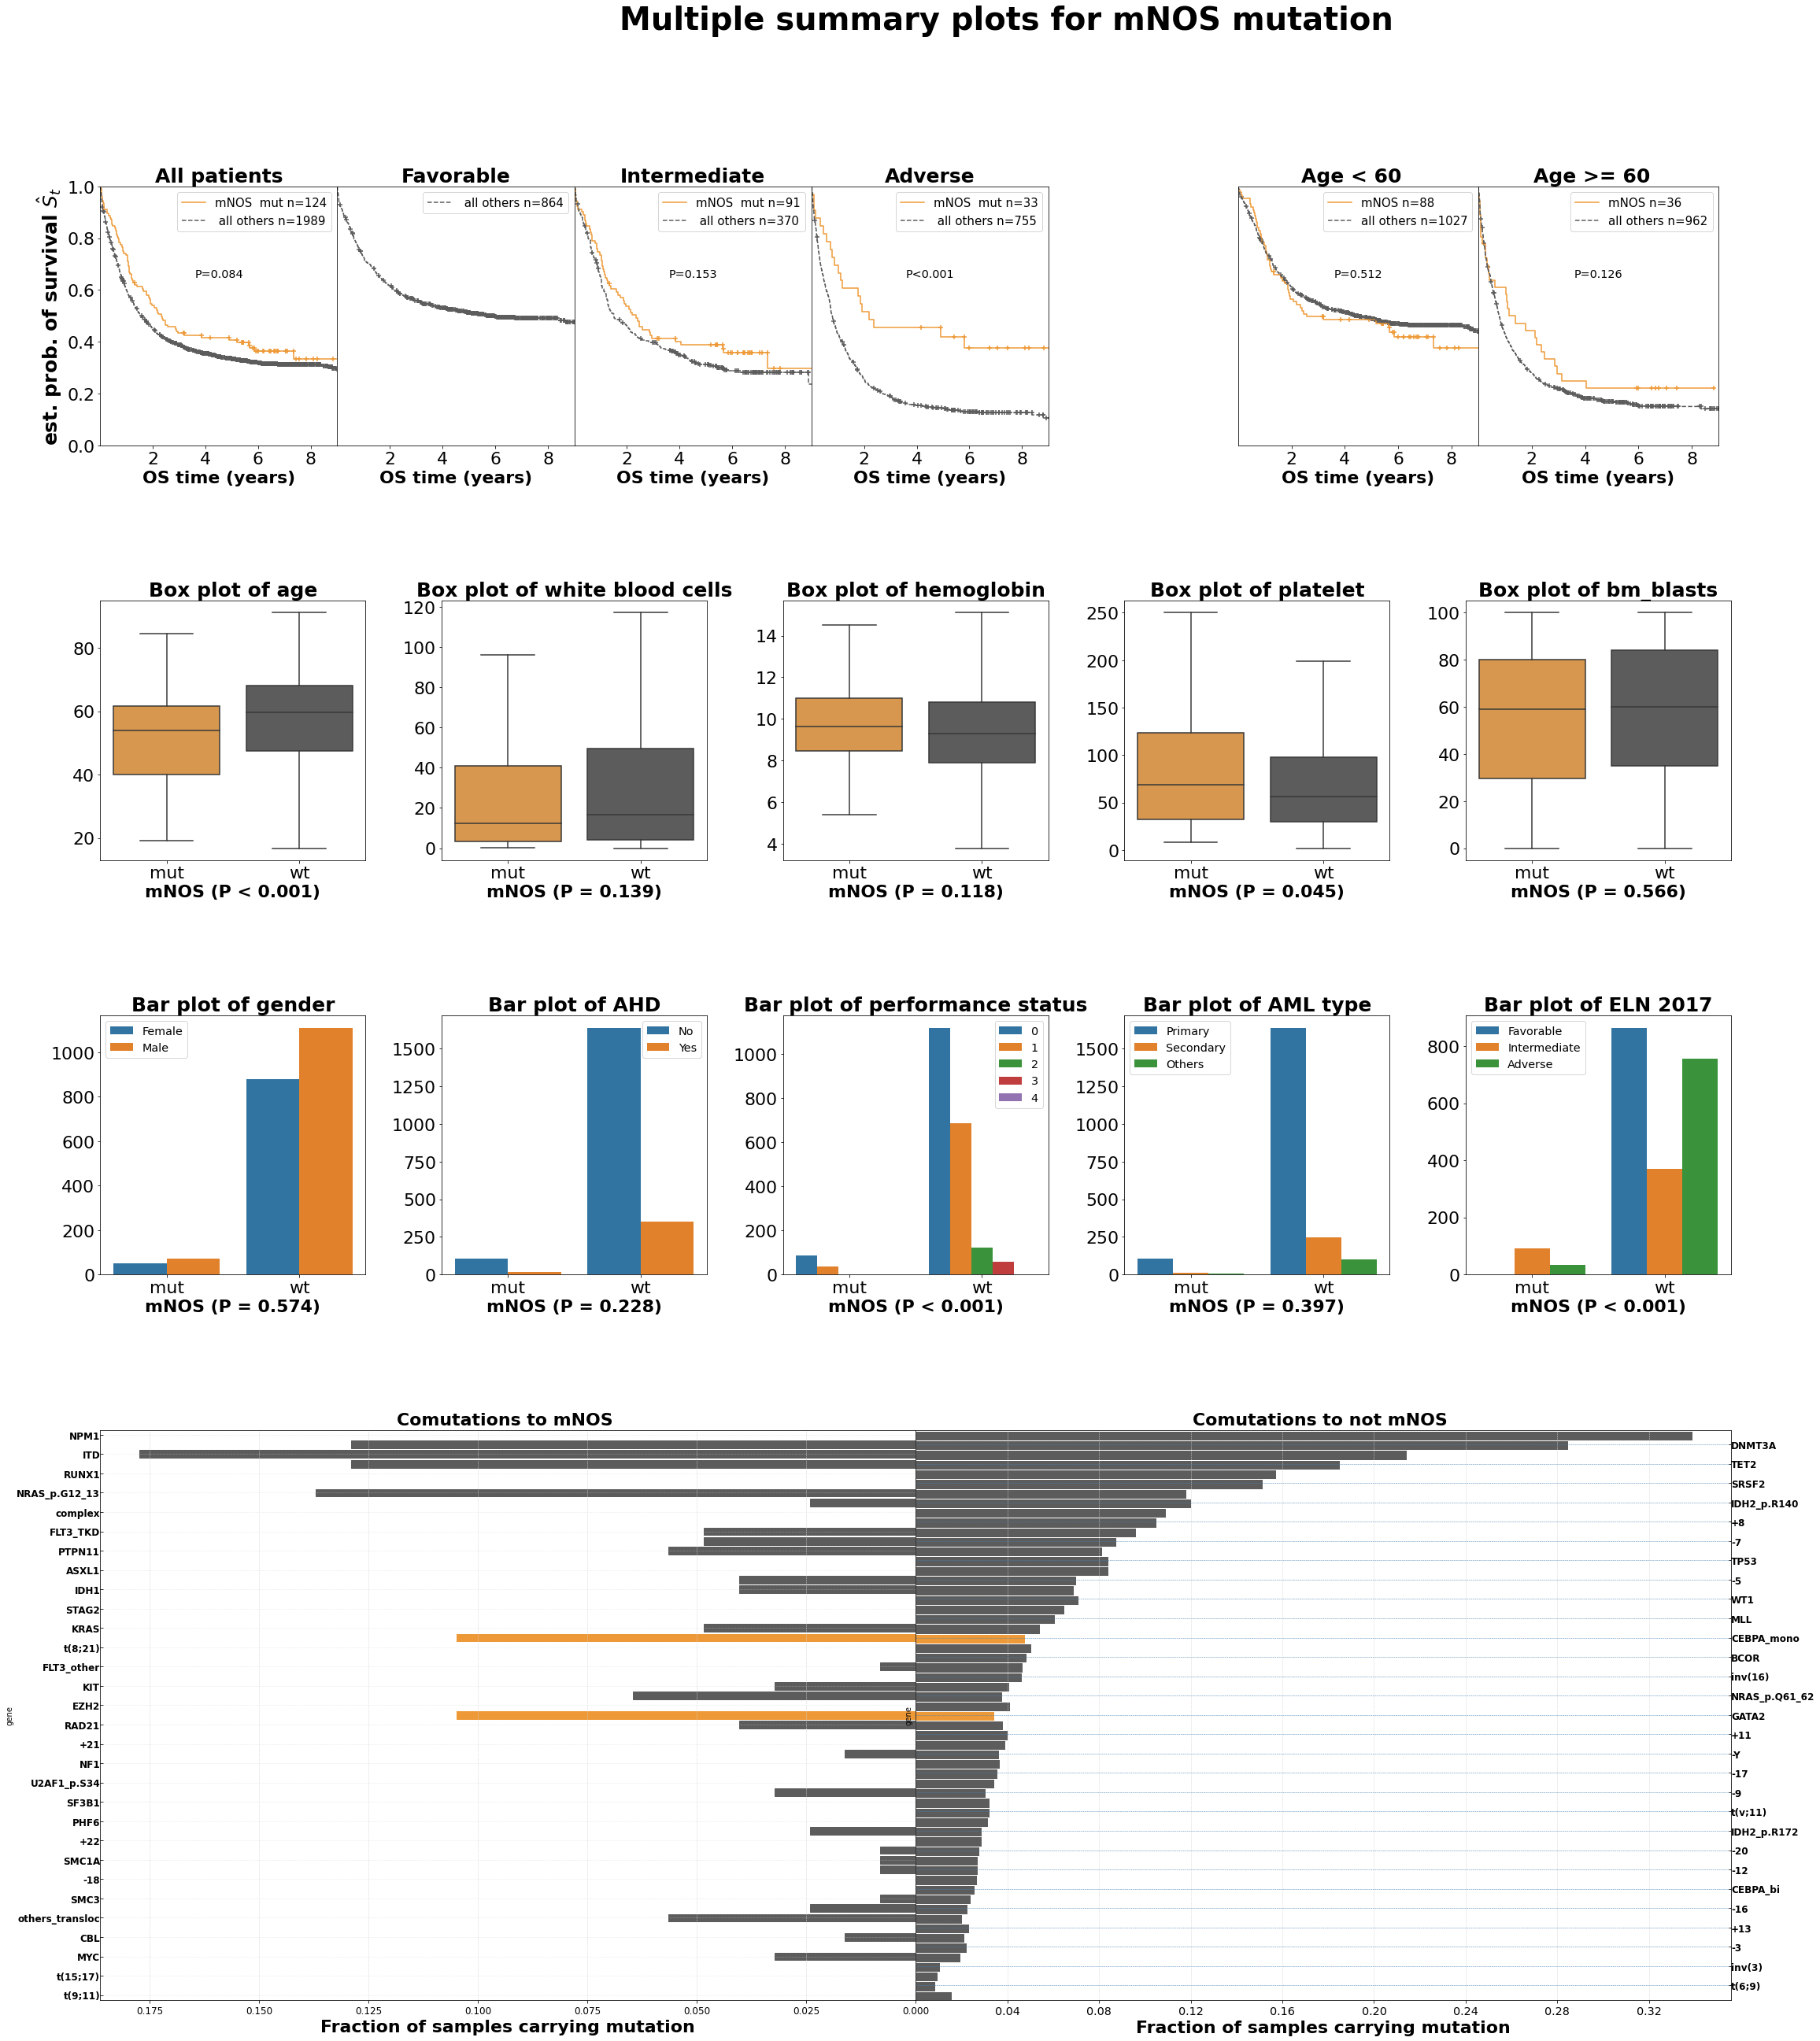

In [13]:
multiplot_events(events_to_plot=molecular_classes[8:9],comutated_events=events_order,display=molecular_classes,save=False,no_separation=True)